#PROBLEM 7: DBSCAN on real data
Run the DBSCAN algorithm on the 20NG dataset, and on the FASHION dataset, and the HouseHold dataset (see papers), and evaluate results. You need to implement both phases (1) neighborhoods creation, (2) DBSCAN.
Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN
DBSCAN Revisited:Mis-Claim, Un-Fixability, and Approximation

EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs

In [1]:
!pip install idx2numpy

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.neighbors import BallTree
import seaborn as sns
drive.mount('/content/drive')
import idx2numpy
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fashion Dataset

In [4]:
# Fashion Train dataset
imgs = idx2numpy.convert_from_file('/content/drive/MyDrive/USML/HW 2B/Fashion/train-images-idx3-ubyte')
lbls = idx2numpy.convert_from_file('/content/drive/MyDrive/USML/HW 2B/Fashion/train-labels-idx1-ubyte')
imgs_flat = imgs.reshape(imgs.shape[0],-1)

In [5]:
fashion_ball_tree = BallTree(imgs_flat,metric='euclidean')

## Attempt 1 - To find appropriate Eps

In [6]:
boot = imgs_flat[0] # lbl = 9
tshirt = imgs_flat[1] # lbl = 0
dress = imgs_flat[3] # lbl = 3
pullover = imgs_flat[5] # lbl = 2
sneaker = imgs_flat[6] # lbl = 7
sandal = imgs_flat[8] # lbl = 5
trouser = imgs_flat[16] # lbl = 1
shirt = imgs_flat[18] # lbl = 6
coat = imgs_flat[19] # lbl = 4
bag = imgs_flat[35] # lbl = 8



In [35]:
def accuracy(radius,img,img_lbl,img_lbl_name):
  similar_imgs = fashion_ball_tree.query_radius([img], r=radius)
  indices_of_similar_imgs = similar_imgs[0]
  correct_lbl = 0
  for idx in indices_of_similar_imgs:
    if lbls[idx] == img_lbl:
      correct_lbl += 1
  total_lbls = len(indices_of_similar_imgs)
  accu = (correct_lbl/total_lbls) * 100
  print(f"For radius {radius}, class {img_lbl_name} is correctly classified {accu:.2f}% out of {total_lbls}")
  return accu

In [51]:
radius = 1625
img_sample = {
    'boot': [boot,radius,9],
    'tshirt': [tshirt,radius,0],
    'dress': [dress,radius,3],
    'pullover': [pullover,radius,2],
    'sneaker': [sneaker,radius,7],
    'sandal': [sandal,radius,5],
    'trouser': [trouser,radius,1],
    'shirt': [shirt,radius,6],
    'coat': [coat,radius,4],
    'bag': [bag,radius,8]
}
avg_accuracy = 0
for lbl_name,(img,radius,lbl) in img_sample.items():
  avg_accuracy += accuracy(radius,img,lbl,lbl_name)

print(f"Average Accuracy:{avg_accuracy/10} ")

For radius 1625, class boot is correctly classified 94.47% out of 199
For radius 1625, class tshirt is correctly classified 96.83% out of 852
For radius 1625, class dress is correctly classified 21.79% out of 3221
For radius 1625, class pullover is correctly classified 81.76% out of 669
For radius 1625, class sneaker is correctly classified 89.32% out of 3455
For radius 1625, class sandal is correctly classified 91.82% out of 318
For radius 1625, class trouser is correctly classified 94.68% out of 1033
For radius 1625, class shirt is correctly classified 28.94% out of 2426
For radius 1625, class coat is correctly classified 11.58% out of 5641
For radius 1625, class bag is correctly classified 77.11% out of 450
Average Accuracy:68.8304669488624 


## Attempt 2 - To find Eps

In [135]:
# Determining EPS and MINPTS
# 1. Calculate distance of k-th nearest neighbor for each point
# 2. Plot in ascending / descending order
# 3. Set EPS to max distance before “jump”
# 4. Set Minpts to k.
def determineEpsAndMinPts(k, ball_tree, data):
  distances, indices = ball_tree.query(data,k=k)
  kth_distances = distances[:,-1]
  kth_distances.sort()
  plt.plot(kth_distances)
  plt.show()

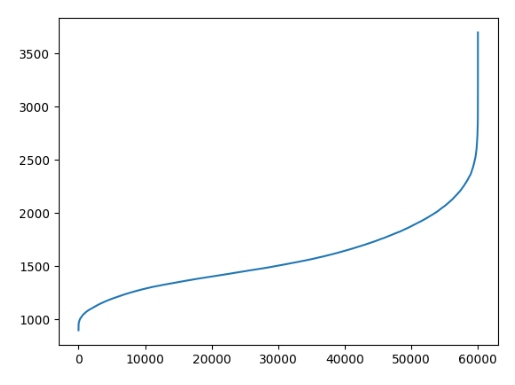

In [115]:
determineEpsAndMinPts(785, fashion_ball_tree, imgs_flat)

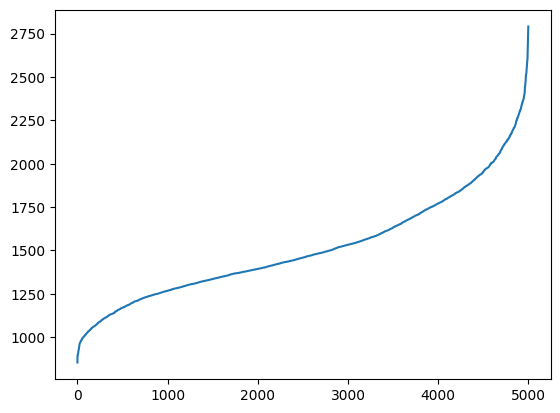

In [155]:
sample_indices = np.random.choice(imgs_flat.shape[0], 5000, replace=False)
sampled_imgs = imgs_flat[sample_indices]
sampled_ball_tree = BallTree(sampled_imgs,metric='euclidean')
determineEpsAndMinPts(k=50, ball_tree = sampled_ball_tree, data = sampled_imgs)

## DBSCAN

In [97]:
# returns index of neighbors
def RangeQuery(DB, ball_tree, pt_idx, eps):
  return ball_tree.query_radius([DB[pt_idx]], r=eps)[0]

In [104]:
def DBSCAN(DB, ball_tree, eps, minPts = 785):
  c = 0
  idx = 0
  lbl = [None for i in range(len(DB))]

  while idx < DB.shape[0]:
    if(lbl[idx] is not None):
      idx+=1
      continue
    N = RangeQuery(DB, ball_tree, idx, eps)
    if(len(N) < minPts):
      lbl[idx] = -1 # lbl of -1 means noise
      idx+=1
      continue

    c += 1
    lbl[idx] = c

    seedset = []
    seedset.extend(N)
    seedset.remove(idx)

    while len(seedset)>0:
      pt = seedset.pop(0)

      if(lbl[pt] == -1):
        lbl[pt] = c

      elif(lbl[pt] is not None):
        continue

      lbl[pt] = c
      N = RangeQuery(DB, ball_tree, pt, eps)

      if(len(N) >= minPts):
        seedset.extend(N)

    idx+=1
  return lbl

In [178]:
sample_indices = np.random.choice(imgs_flat.shape[0], 1000, replace=False)
sampled_imgs = imgs_flat[sample_indices]
sampled_ball_tree = BallTree(sampled_imgs,metric='euclidean')

In [179]:
labels = DBSCAN(sampled_imgs, sampled_ball_tree, eps = 1200, minPts = 3)
value_counts = Counter(labels)
value_counts

Counter({1: 444,
         -1: 484,
         2: 11,
         3: 21,
         4: 11,
         6: 7,
         5: 4,
         8: 3,
         7: 4,
         10: 3,
         11: 3,
         9: 5})

### Evaluation (Purity)

In [182]:
def purity(algo_det_lbls, sample_indices):
  # Confusion matrix of algorithm determined cluster indices (row) vs true cluster indices (column)
  # purity = sum of row wise max / total data points

  true_lbls = lbls[sample_indices]
  cm = np.zeros((len(set(labels)),len(set(true_lbls))), dtype=int)

  for i in range(len(algo_det_lbls)):
    algo_det_lbl = algo_det_lbls[i]
    true_lbl = lbls[i]
    cm[algo_det_lbl][true_lbl] += 1

  Pj_sum = np.sum(np.max(cm,axis=1))
  print(f"Purity: {Pj_sum/len(algo_det_lbls)}")

purity(labels,sample_indices)

Purity: 0.131


# UCI Household Dataset

In [ ]:
# # Cleaning UCI Household dataset
# df = pd.read_csv('/content/drive/MyDrive/USML/HW 2B/household_power_consumption.txt', delimiter=';')
# df.drop(columns=['Date','Time'], inplace=True)
# df.replace('?', np.nan, inplace=True)
# df = df.astype(float)
# df.dropna(inplace=True)
# numpy_array = df.values
# with open('/content/drive/MyDrive/USML/HW 2B/numpy_array.pkl', 'wb') as f:
#     pickle.dump(numpy_array, f)

In [108]:
with open('/content/drive/MyDrive/USML/HW 2B/UCI Household Dataset/numpy_array.pkl', 'rb') as f:
    household = pickle.load(f)

In [109]:
household.shape

(2049280, 7)

In [110]:
sample_indices = np.random.choice(household.shape[0], 2000, replace=False)
sampled_recs = household[sample_indices]
ball_tree = BallTree(sampled_recs,metric='euclidean')

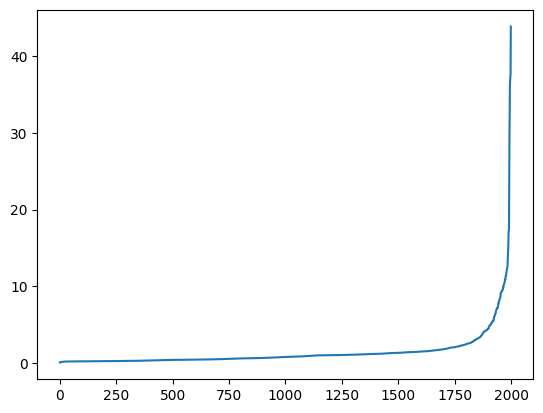

In [111]:
determineEpsAndMinPts(8, ball_tree, sampled_recs)

In [112]:
labels = DBSCAN(sampled_recs, ball_tree, eps = 2.5, minPts = 8)

In [113]:
value_counts = Counter(labels)
value_counts

Counter({1: 561, 2: 1252, -1: 149, 3: 25, 4: 13})